Faith Busche
ML - CS 584
Final Project - Take Dataset and Use Visualization Strategies

In [1]:
%pip install seaborn
%pip install scikit-learn
%pip install umap-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load and Preprocess Dataset

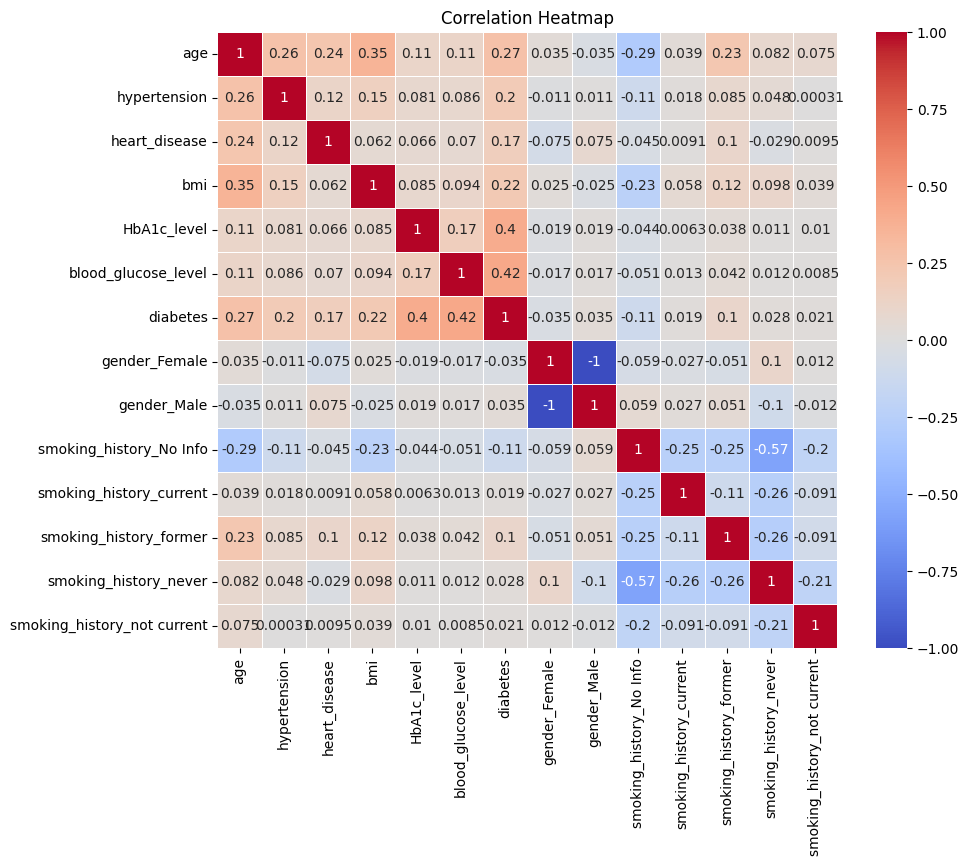

In [33]:
# Load the dataset from the CSV file
df = pd.read_csv("diabetes_prediction_dataset.csv")
#df = df[0:10000]

#Remove duplicates
df = df.drop_duplicates()
#Remove Other category
df = df[df['gender'] != 'Other']
#Remove 'ever' category
df = df[df['smoking_history'] != 'ever']

# Encode categorical variables (e.g., "gender" and "smoking_history") as numeric values for correlation analysis
df_encoded = pd.get_dummies(df, columns=["gender", "smoking_history"])

# Compute the correlation matrix and create a correlation heatmap
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Dimensionality Reduction

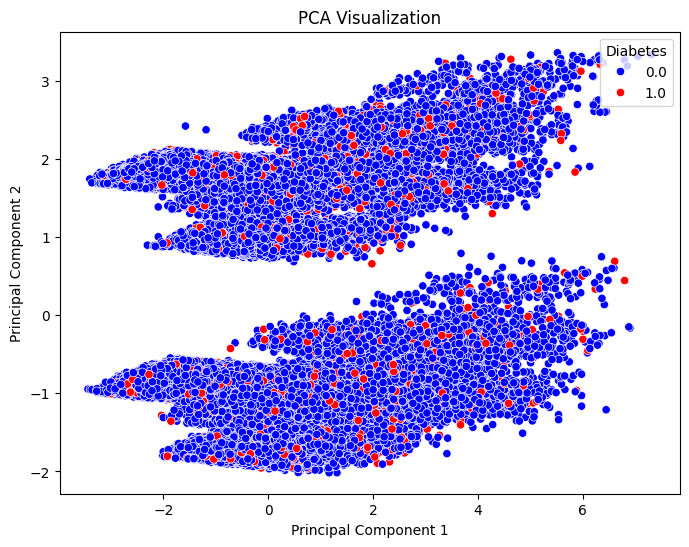

In [34]:
# Standardize the data (important for PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components for 2D visualization
principal_components = pca.fit_transform(df_scaled)

# Create a DataFrame for the reduced data
df_pca = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

# Add back the "diabetes" column for color-coding the plot
df_pca["diabetes"] = df["diabetes"]

# Create a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", data=df_pca, hue="diabetes", palette=["blue", "red"])
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Diabetes", loc="upper right")
plt.show()

In [35]:
# After fitting the PCA model
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# Access the loadings (weights) of the original features for PC1 and PC2
loadings = pca.components_

# Create a DataFrame to display the feature labels and their corresponding weights for PC1 and PC2
loadings_df = pd.DataFrame(loadings, columns=df_encoded.columns, index=["PC1", "PC2"])
print("Loadings (Weights) for PC1 and PC2:")
print(loadings_df)

Loadings (Weights) for PC1 and PC2:
          age  hypertension  heart_disease       bmi  HbA1c_level  \
PC1  0.442303      0.286169       0.219481  0.356249     0.264889   
PC2 -0.016375      0.029968       0.123372 -0.033187     0.071721   

     blood_glucose_level  diabetes  gender_Female  gender_Male  \
PC1             0.278578  0.426282       0.019134    -0.019134   
PC2             0.071759  0.099699      -0.659546     0.659546   

     smoking_history_No Info  smoking_history_current  smoking_history_former  \
PC1                -0.370106                 0.056001                0.212009   
PC2                 0.151411                 0.047464                0.101102   

     smoking_history_never  smoking_history_not current  
PC1               0.169714                     0.057478  
PC2              -0.238371                    -0.007593  


# Random Forest Classifier Model
Here we predict whether a person is at risk of diabetes with a base random classifier model and analyze performance with cross validation

Fold 1 Accuracy: 0.9397623053128561
Fold 2 Accuracy: 0.9374796483230218
Fold 3 Accuracy: 0.93682839465972
Fold 4 Accuracy: 0.9369369369369369
Fold 5 Accuracy: 0.9379138174318897

Average Accuracy: 0.937784220532885


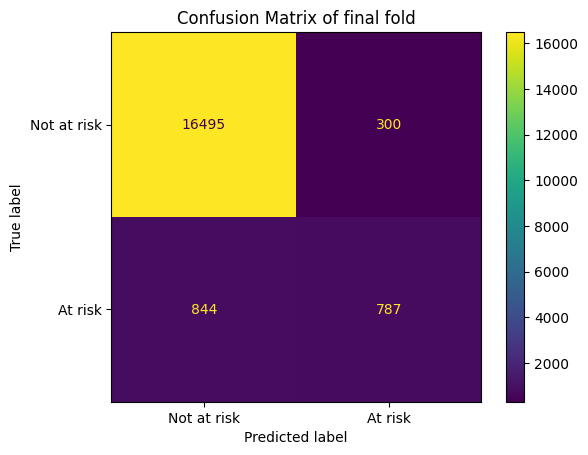

In [54]:
# Assuming 'X' contains the features and 'y' contains the target variable ('diabetes')
X = df_encoded.drop("diabetes", axis=1)
y = df_encoded["diabetes"]

# Define the number of folds (k)
k = 5

# Initialize the k-fold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the classifier (replace with the classifier of your choice)
classifier = RandomForestClassifier()

# Initialize PCA
pca = PCA(n_components=2)

# Perform k-fold cross-validation
fold_accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Fit the model on the training data
    classifier.fit(X_train_pca, y_train)

    # Make predictions on the test data
    predictions = classifier.predict(X_test_pca)

    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, predictions)
    fold_accuracies.append(accuracy)

# Print the accuracy for each fold
for i, accuracy in enumerate(fold_accuracies, 1):
    print(f"Fold {i} Accuracy: {accuracy}")

# Calculate and print the average accuracy across all folds
average_accuracy = sum(fold_accuracies) / k
print(f"\nAverage Accuracy: {average_accuracy}")

#Display a confusion matrix of the final validation fold
cm = confusion_matrix(y_test, predictions)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not at risk', 'At risk'])
cm_plot.plot()
plt.title('Confusion Matrix of final fold')
plt.show()

# Random Forest Classifier Model with tuned Hyperparameters
Here we attempt to fine tune the hyperparameters of the Random Forest Classifier to improve model performance.

Fold 1 Accuracy: 0.9479568025180442
Fold 2 Accuracy: 0.9457831325301205
Fold 3 Accuracy: 0.9449147943123847
Fold 4 Accuracy: 0.9481167914902855
Fold 5 Accuracy: 0.9473569955497666

Average Accuracy: 0.9468257032801203


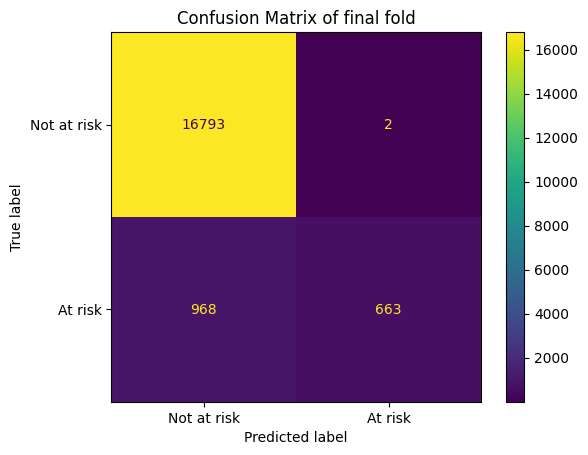

In [53]:
# Define the number of folds (k)
k = 5

# Initialize the k-fold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the classifier 
# Set the maximum depth of each tree and minimum number of samples required to split an internal node
classifier = RandomForestClassifier(n_estimators=13, max_depth=2, min_samples_split=2)

# Initialize PCA
pca = PCA(n_components=2)

# Perform k-fold cross-validation
fold_accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Fit the model on the training data
    classifier.fit(X_train_pca, y_train)

    # Make predictions on the test data
    predictions = classifier.predict(X_test_pca)

    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, predictions)
    fold_accuracies.append(accuracy)

# Print the accuracy for each fold
for i, accuracy in enumerate(fold_accuracies, 1):
    print(f"Fold {i} Accuracy: {accuracy}")

# Calculate and print the average accuracy across all folds
average_accuracy = sum(fold_accuracies) / k
print(f"\nAverage Accuracy: {average_accuracy}")

#Display a confusion matrix of the final validation fold
cm = confusion_matrix(y_test, predictions)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not at risk', 'At risk'])
cm_plot.plot()
plt.title('Confusion Matrix of final fold')
plt.show()


# Logistic Regression Model
Here we use a logistic regression model classifier instead to observe its effects on model performance

Fold 1 Accuracy: 0.939816573506268
Fold 2 Accuracy: 0.9387278845110171
Fold 3 Accuracy: 0.9369912080755455
Fold 4 Accuracy: 0.9403560186692717
Fold 5 Accuracy: 0.9383479865407576

Average Accuracy: 0.938847934260572


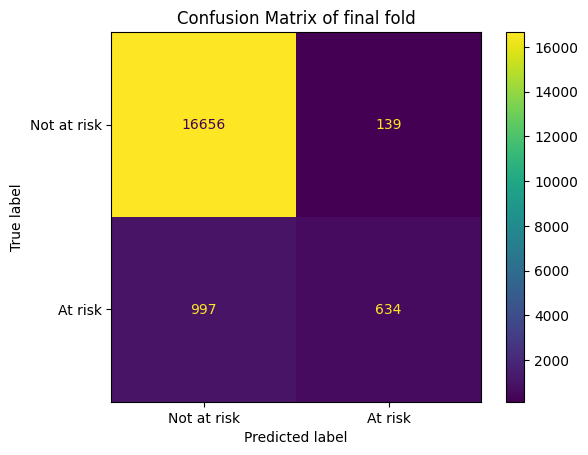

In [52]:
from sklearn.linear_model import LogisticRegression 

# Define the number of folds (k)
k = 5

# Initialize the k-fold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=42)

classifier = LogisticRegression(random_state=42)

# Initialize PCA
pca = PCA(n_components=2)

# Perform k-fold cross-validation
fold_accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Fit the model on the training data
    classifier.fit(X_train_pca, y_train)

    # Make predictions on the test data
    predictions = classifier.predict(X_test_pca)

    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, predictions)
    fold_accuracies.append(accuracy)

# Print the accuracy for each fold
for i, accuracy in enumerate(fold_accuracies, 1):
    print(f"Fold {i} Accuracy: {accuracy}")

# Calculate and print the average accuracy across all folds
average_accuracy = sum(fold_accuracies) / k
print(f"\nAverage Accuracy: {average_accuracy}")

#Display a confusion matrix of the final validation fold
cm = confusion_matrix(y_test, predictions)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not at risk', 'At risk'])
cm_plot.plot()
plt.title('Confusion Matrix of final fold')
plt.show()

# Logistic Regression Model with Regularization 
Here we apply ridge regression to the Logistic Regression model to attempt to improve its performance

Fold 1 Accuracy: 0.939816573506268
Fold 2 Accuracy: 0.9387278845110171
Fold 3 Accuracy: 0.9370454792141539
Fold 4 Accuracy: 0.9403560186692717
Fold 5 Accuracy: 0.9383479865407576

Average Accuracy: 0.9388587884882937


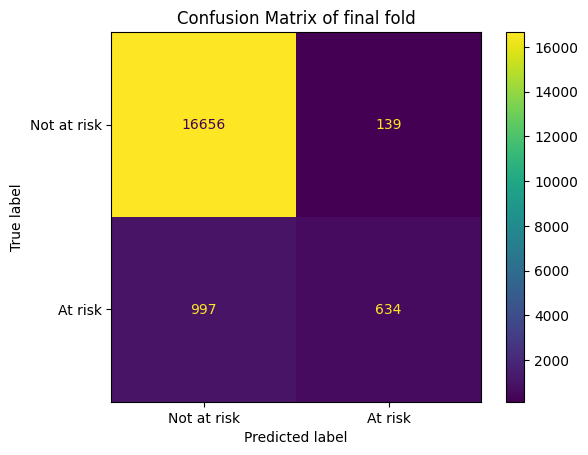

In [51]:
from sklearn.linear_model import LogisticRegression 

# Define the number of folds (k)
k = 5

# Initialize the k-fold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Create the Logistic Regression model with regularization
#Use penalty='l1' for lasso regression and penalty='l2' for ridge regression
classifier = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Initialize PCA
pca = PCA(n_components=2)

# Perform k-fold cross-validation
fold_accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Fit the model on the training data
    classifier.fit(X_train_pca, y_train)

    # Make predictions on the test data
    predictions = classifier.predict(X_test_pca)

    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, predictions)
    fold_accuracies.append(accuracy)

# Print the accuracy for each fold
for i, accuracy in enumerate(fold_accuracies, 1):
    print(f"Fold {i} Accuracy: {accuracy}")

# Calculate and print the average accuracy across all folds
average_accuracy = sum(fold_accuracies) / k
print(f"\nAverage Accuracy: {average_accuracy}")

#Display a confusion matrix of the final validation fold
cm = confusion_matrix(y_test, predictions)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not at risk', 'At risk'])
cm_plot.plot()
plt.title('Confusion Matrix of final fold')
plt.show()

# Overall Assessment
Each model tested was able to achieve high accuracy for predicting which patients had diabetes based on the features gender, age, hypertension, heart disease, smoking history, BMI, HbA1c level, and blood glucose level. 

The random forest classifier model saw improved accuracy after tuning the parameters of its decision trees.

The logistic regression model also had improved accuracy by using ridge regression.

These improvements were expected although small due to the base models already having good performance.